# Import Part

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
import imghdr
from time import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import kaggle

# GPU using

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5292)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

ValueError: Cannot set memory growth on device when virtual devices configured

# Kagggle API downloading

In [4]:
kaggle.api.dataset_download_files(dataset = "mhmmadalewi/buildings-vs-forests", path='new_dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mhmmadalewi/buildings-vs-forests


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Settings parameters

In [6]:
DATA_DIR = "new_dataset"
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
EPOCHS = 1000
LOG_DIR = "logs"
learning_rate = 0.00001 

In [7]:
TRAINING_DIR = "new_dataset"
TEST_DIR = "new_dataset"
VAL_SPLIT = 0.2 

# Data split

In [8]:
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [9]:
train_generator = data_gen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 4284 images belonging to 2 classes.


In [10]:
val_generator = data_gen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1070 images belonging to 2 classes.


In [11]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5354 images belonging to 2 classes.


# Model

In [20]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid') 
])

In [21]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

In [23]:
with tf.device('/GPU:0'):
    early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    min_delta=0.001,  
    restore_best_weights=True
    )
    history = cnn_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[tensorboard_callback, early_stopping]
    )

Epoch 1/1000
134/134 [==============================] - 11s 75ms/step - loss: 0.5658 - accuracy: 0.7740 - val_loss: 0.5104 - val_accuracy: 0.7505
Epoch 2/1000
134/134 [==============================] - 10s 74ms/step - loss: 0.3591 - accuracy: 0.8508 - val_loss: 0.3518 - val_accuracy: 0.8551
Epoch 3/1000
134/134 [==============================] - 10s 74ms/step - loss: 0.3095 - accuracy: 0.8768 - val_loss: 0.2781 - val_accuracy: 0.8991
Epoch 4/1000
134/134 [==============================] - 10s 74ms/step - loss: 0.2559 - accuracy: 0.8978 - val_loss: 0.2747 - val_accuracy: 0.9019
Epoch 5/1000
134/134 [==============================] - 10s 73ms/step - loss: 0.2467 - accuracy: 0.9050 - val_loss: 0.2542 - val_accuracy: 0.9140
Epoch 6/1000
134/134 [==============================] - 10s 74ms/step - loss: 0.2259 - accuracy: 0.9139 - val_loss: 0.2491 - val_accuracy: 0.9131
Epoch 7/1000
134/134 [==============================] - 10s 74ms/step - loss: 0.2119 - accuracy: 0.9202 - val_loss: 0.2573 -

In [24]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

168/168 [==============================] - 4s 25ms/step - loss: 0.2519 - accuracy: 0.9105
Test Accuracy: 0.9105


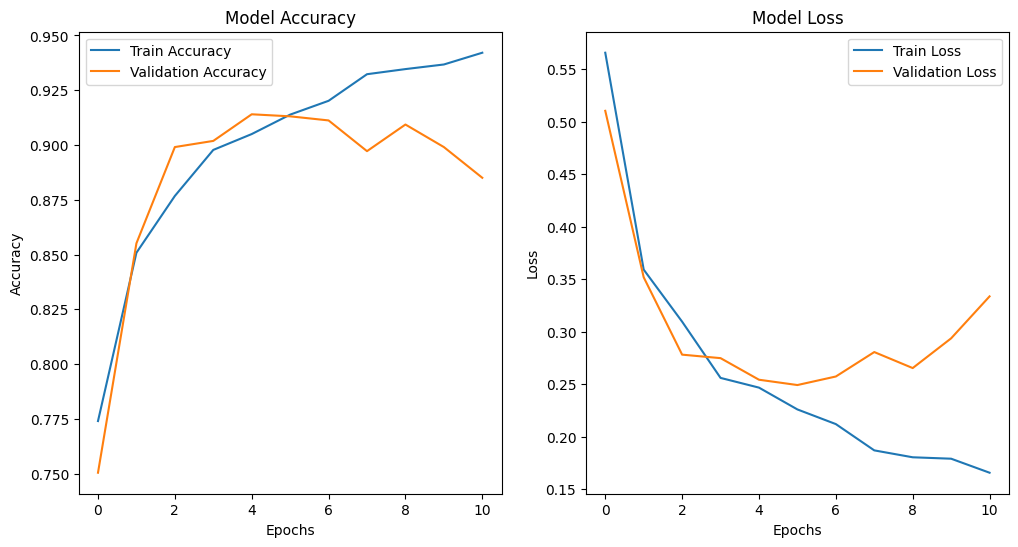

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Embeddings Visualisation

In [26]:
embedding_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

embeddings = []
labels = []

for images, lbls in val_generator:
    emb = embedding_model.predict(images)
    embeddings.append(emb)
    labels.append(lbls)
    if len(embeddings) * BATCH_SIZE >= len(val_generator.filenames):
        break

1/1 [==============================] - 0s 220ms/step


In [27]:
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

In [28]:
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

E:\ProgramFiles\Anaconda\envs\NEW_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
E:\ProgramFiles\Anaconda\envs\NEW_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


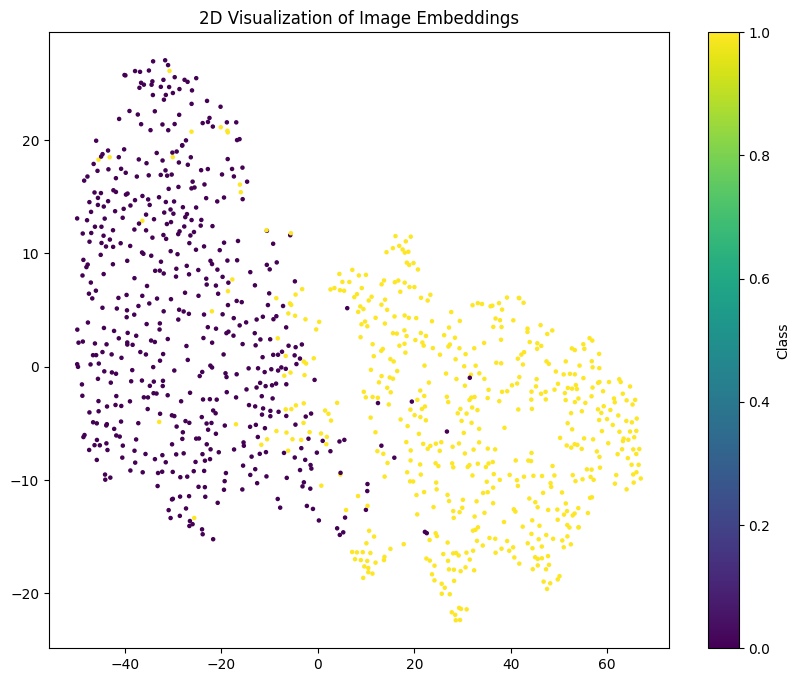

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar(label='Class')
plt.title('2D Visualization of Image Embeddings')
plt.show()


# Transfer model

In [45]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

In [46]:
transfer_model = Sequential([
    base_model,  
    GlobalAveragePooling2D(),  
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    BatchNormalization(), 
    Dropout(0.5), 
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

In [47]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
with tf.device('/GPU:0'):
    early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    min_delta=0.001,  
    restore_best_weights=True
    )
    history = transfer_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )

Epoch 1/1000
134/134 [==============================] - 18s 110ms/step - loss: 5.9462 - accuracy: 0.9244 - val_loss: 5.5857 - val_accuracy: 0.9850
Epoch 2/1000
134/134 [==============================] - 14s 106ms/step - loss: 5.2456 - accuracy: 0.9879 - val_loss: 4.9156 - val_accuracy: 0.9897
Epoch 3/1000
134/134 [==============================] - 14s 106ms/step - loss: 4.5742 - accuracy: 0.9928 - val_loss: 4.2535 - val_accuracy: 0.9879
Epoch 4/1000
134/134 [==============================] - 14s 106ms/step - loss: 3.9003 - accuracy: 0.9963 - val_loss: 3.5779 - val_accuracy: 0.9953
Epoch 5/1000
134/134 [==============================] - 14s 105ms/step - loss: 3.2641 - accuracy: 0.9967 - val_loss: 2.9590 - val_accuracy: 0.9981
Epoch 6/1000
134/134 [==============================] - 14s 105ms/step - loss: 2.6928 - accuracy: 0.9979 - val_loss: 2.4252 - val_accuracy: 0.9972
Epoch 7/1000
134/134 [==============================] - 14s 107ms/step - loss: 2.1808 - accuracy: 0.9995 - val_loss: 1

In [49]:
test_loss, test_acc = transfer_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

168/168 [==============================] - 5s 27ms/step - loss: 0.0142 - accuracy: 1.0000
Test Accuracy: 1.0000


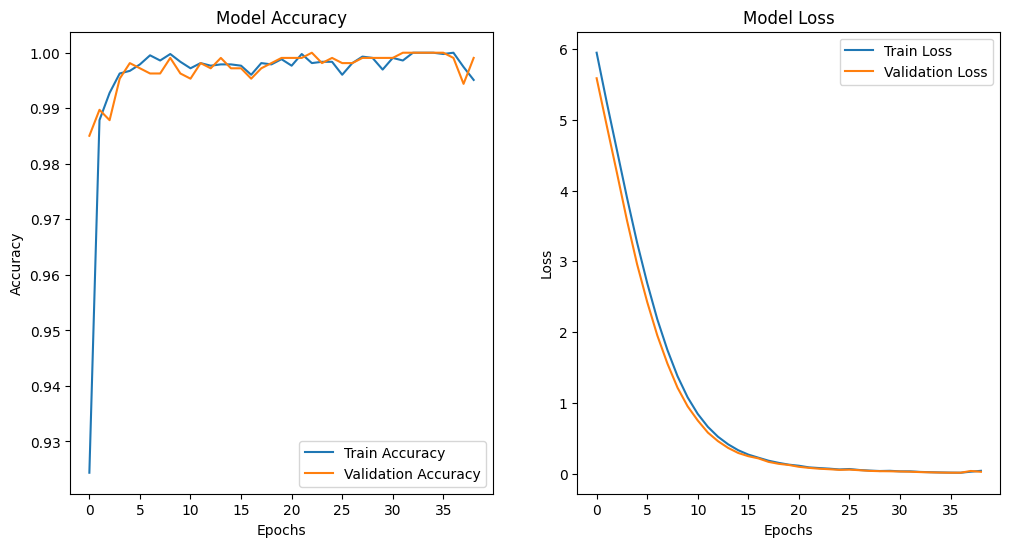

In [50]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()